<a href="https://colab.research.google.com/github/hideaki-kyutech/syseng2025/blob/main/compress_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ライブラリのインポート
- numpy: 数値計算（特に行列演算）
- PIL: 画像処理
- random: 乱数生成
- io: 入出力管理
- matplotlib.pyplot: プロット、描画
- psnr: PSNR(peak to signal ratio: SN比)

In [ ]:
import numpy as np
from PIL import Image
import random
import io
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# 画像の読み込みと前処理

In [16]:
# 画像読み込み（GoogleDriveをマウントして、パスを適宜変更）
img_path = '/content/drive/MyDrive/Colab Notebooks/2025/syseng/sample_bird.png'
img = Image.open(img_path).convert('RGB')
img = img.resize((256, 256))  # サイズ調整
block_size = 64
qualities = [95, 50, 5] # JPEG圧縮品質スコアリスト(95:高品質, 50:中品質, 5: 低品質)

# 画像圧縮関数
- ブロック画像(block)と、JPEG品質(quality)を引数として受け取り、圧縮画像とそのサイズ(bytes)を返す

In [17]:
# 圧縮関数：圧縮した画像とバイトサイズを返す
def compress_block(block, quality):
    buffer = io.BytesIO() #内部メモリ領域の確保
    block.save(buffer, format='JPEG', quality=quality)
    size = buffer.tell()  # バイト数（ファイルサイズ）
    buffer.seek(0) # 内部メモリのポインタをリセット
    return Image.open(buffer), size

# ブロック毎の圧縮処理

In [20]:
compressed_img = Image.new('RGB', img.size) # 空の画像を生成
total_bytes = 0

# 各ブロックを処理
for y in range(0, img.height, block_size): # block_size刻みでimg.heightまで
    for x in range(0, img.width, block_size): # block_size刻みでimg.widthまで
        block = img.crop((x, y, x + block_size, y + block_size)) # ブロック切り出し
        q = random.choice(qualities) # ブロックの圧縮品質をランダムで設定
        compressed_block, block_bytes = compress_block(block, q)
        compressed_img.paste(compressed_block, (x, y)) # 圧縮ブロックを画像に格納
        total_bytes += block_bytes

# 品質評価

合計ビット数（概算）: 21,555 bytes
PSNR（全体）: 28.03 dB


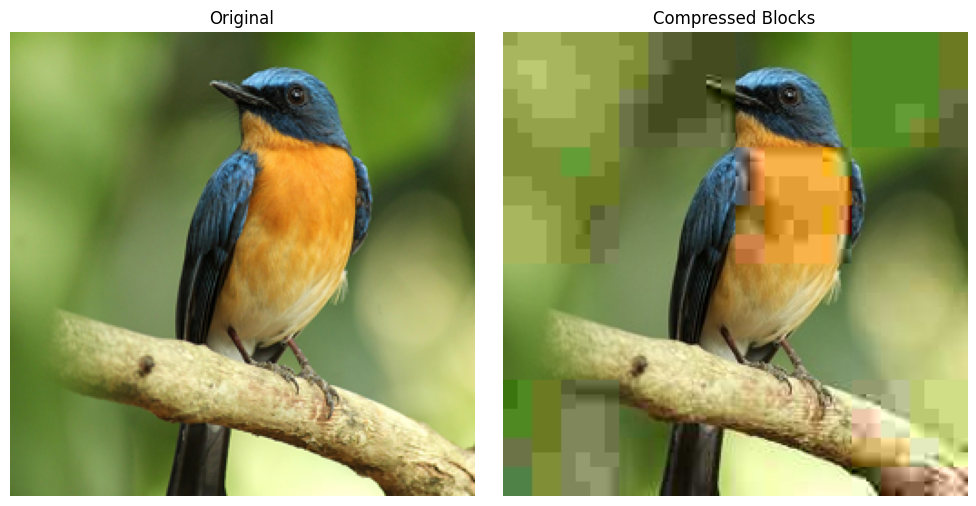

In [21]:
# PSNRの計算
img_np = np.array(img)
compressed_np = np.array(compressed_img)

# PSNR (チャンネルごとの平均)
psnr_r = psnr(img_np[:, :, 0], compressed_np[:, :, 0])
psnr_g = psnr(img_np[:, :, 1], compressed_np[:, :, 1])
psnr_b = psnr(img_np[:, :, 2], compressed_np[:, :, 2])
final_psnr = (psnr_r + psnr_g + psnr_b) / 3

# ビット数表示（8ビット × バイト数）
#total_bits = total_bytes * 8

# 結果表示
print(f"合計ビット数（概算）: {total_bytes:,} bytes")
print(f"PSNR（全体）: {final_psnr:.2f} dB")

# 表示
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Compressed Blocks")
plt.imshow(compressed_img)
plt.axis('off')

plt.tight_layout()
plt.show()